In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/John-Blodgett/CSC466-Project/main/total_data.csv')
# df = df.drop('file dist of bytes', axis=1)
df['hash dist'] = df['hash dist'].apply(eval)
df['file dist of bytes'] = df['file dist of bytes'].apply(eval)
df_dist = pd.DataFrame(df['hash dist'].to_list(), 
                       index=df.index, 
                       columns=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f'])
df_dist['hash type'] = df['hash type']

df.append(df_dist)
df.drop(['hash dist', 'hash'], axis=1, inplace=True)

df[['consecutiveCount', 'file size (bytes)']] = StandardScaler().fit_transform(df[['consecutiveCount', 'file size (bytes)']])

df = pd.get_dummies(df, columns=['file type', 'consecutiveByte'])

df

,file dist of bytes,consecutiveCount,hash type,hash len,hash 0 bits,hash 1 bits,hash len bits,file size (bytes),file type_.jpg,file type_.json,file type_.pdf,file type_.txt,"consecutiveByte_b""'""",consecutiveByte_b' ',consecutiveByte_b'!',"consecutiveByte_b'""'",consecutiveByte_b'(',consecutiveByte_b'-',consecutiveByte_b'.',consecutiveByte_b'0',consecutiveByte_b'1',consecutiveByte_b'2',consecutiveByte_b'3',consecutiveByte_b'4',consecutiveByte_b'5',consecutiveByte_b'6',consecutiveByte_b'7',consecutiveByte_b'8',consecutiveByte_b'9',consecutiveByte_b';',consecutiveByte_b'>',consecutiveByte_b'?',consecutiveByte_b'@',consecutiveByte_b'A',consecutiveByte_b'B',consecutiveByte_b'D',consecutiveByte_b'O',consecutiveByte_b'P',consecutiveByte_b'Q',consecutiveByte_b'U',...,consecutiveByte_b'\x11',consecutiveByte_b'\x14',consecutiveByte_b'\x16',consecutiveByte_b'\x1a',consecutiveByte_b'\x1e',consecutiveByte_b'\x82',consecutiveByte_b'\x83',consecutiveByte_b'\x84',consecutiveByte_b'\x88',consecutiveByte_b'\x8a',consecutiveByte_b'\x8f',consecutiveByte_b'\x91',consecutiveByte_b'\x92',consecutiveByte_b'\x9e',consecutiveByte_b'\xa3',consecutiveByte_b'\xa4',consecutiveByte_b'\xa5',consecutiveByte_b'\xaa',consecutiveByte_b'\xb3',consecutiveByte_b'\xd1',consecutiveByte_b'\xdd',consecutiveByte_b'\xe7',consecutiveByte_b'\xee',consecutiveByte_b'\xf4',consecutiveByte_b'\xf5',consecutiveByte_b'\xff',consecutiveByte_b'_',consecutiveByte_b'a',consecutiveByte_b'b',consecutiveByte_b'c',consecutiveByte_b'd',consecutiveByte_b'e',consecutiveByte_b'f',consecutiveByte_b'h',consecutiveByte_b'i',consecutiveByte_b'o',consecutiveByte_b'p',consecutiveByte_b's',consecutiveByte_b'w',consecutiveByte_b'~'
0,"[185, 71, 61, 64, 62, 43, 59, 58, 47, 49, 108,...",-0.079771,SHA-1,40,69,91,160,-0.226642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[192, 78, 55, 54, 53, 54, 61, 70, 50, 55, 115,...",-0.079771,SHA-256,64,133,123,256,-0.226927,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[181, 80, 57, 57, 63, 60, 63, 70, 44, 44, 115,...",-0.079771,SHA-3-256,64,116,140,256,-0.226016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[215, 68, 51, 73, 52, 57, 52, 55, 40, 43, 102,...",-0.079771,MD5,32,55,73,128,-0.226521,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"[191, 90, 60, 66, 56, 59, 66, 60, 53, 54, 102,...",-0.079771,SHA-256,64,117,139,256,-0.226609,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,"[10194, 3869, 3826, 3705, 3466, 3743, 3592, 38...",-0.061607,SHA-256,64,125,131,256,0.140832,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5246,"[29855, 14763, 15433, 17860, 14182, 15818, 156...",0.175344,SHA-256,64,134,122,256,1.485487,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5247,"[3220, 3164, 3107, 3076, 3088, 3066, 3136, 319...",-0.038490,SHA-256,64,121,135,256,0.238327,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5248,"[1053, 896, 765, 76

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('hash type', axis=1), df['hash type'], test_size=0.2, random_state=0)

# reduce dimensionality of file byte dist (from 256 to around 2 or whatever happens to capture 90% of the variance)
X_train_file_dist = pd.DataFrame(X_train['file dist of bytes'].to_list(),  index=X_train.index)
X_test_file_dist = pd.DataFrame(X_test['file dist of bytes'].to_list(),  index=X_test.index)

scaler = StandardScaler()
scaler.fit(X_train_file_dist)
X_train_file_dist = pd.DataFrame(scaler.transform(X_train_file_dist), index=X_train.index)
X_test_file_dist = pd.DataFrame(scaler.transform(X_test_file_dist), index=X_test.index)

pca = PCA(0.90)
pcs = pca.fit(X_train_file_dist)
# fix this to do x columns not hardcoded 2
X_train_file_dist = pd.DataFrame(pca.transform(X_train_file_dist), index=X_train.index, 
                                 columns=['file dist pca ' + str(i+1) for i in range(len(pca.explained_variance_))])
X_test_file_dist = pd.DataFrame(pca.transform(X_test_file_dist), index=X_test.index,
                                columns=['file dist pca ' + str(i+1) for i in range(len(pca.explained_variance_))])

X_train = X_train.join(X_train_file_dist)
X_train.drop('file dist of bytes', axis=1, inplace=True)
X_test = X_test.join(X_test_file_dist)
X_test.drop('file dist of bytes', axis=1, inplace=True)

In [72]:
def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
      KNeighborsClassifier(n_neighbors=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='accuracy', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

get_cv_error(6)

0.7490476190476191

7     0.743333
12    0.745952
10    0.746190
1     0.746905
8     0.748571
9     0.748810
6     0.749048
5     0.749286
2     0.750476
11    0.750952
14    0.752381
4     0.753333
13    0.755000
16    0.755238
3     0.755714
15    0.757619
17    0.759524
18    0.760000
19    0.764762
dtype: float64

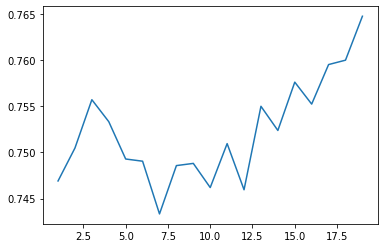

In [73]:
ks = pd.Series(range(1, 20))
ks.index = range(1, 20)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values()

In [74]:
classifier = KNeighborsClassifier(n_neighbors=19)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.47      0.49       265
   SHA-3-256       0.51      0.55      0.53       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [ ]:
def get_cv_error_mlp_iterations(k):
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(max_iter=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


200    0.139307
300    0.160130
100    0.165221
400    0.206194
dtype: float64

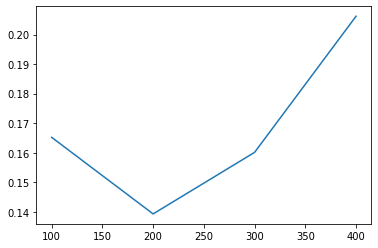

In [ ]:


ks = pd.Series(range(100, 500, 100))
ks.index = range(100, 500, 100)
test_errs = ks.apply(get_cv_error_mlp_iterations)

test_errs.plot.line()
test_errs.sort_values()



In [ ]:
def get_cv_error_mlp_hidden_layers(k):
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(hidden_layer_sizes=k, max_iter=300)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


175    0.179186
125    0.183127
100    0.184660
150    0.184906
225    0.197744
200    0.215711
dtype: float64

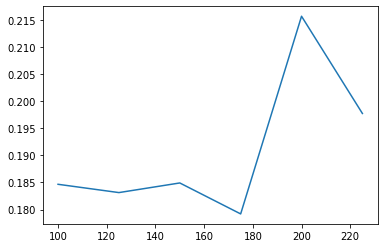

In [ ]:

ks = pd.Series(range(100, 250, 25))
ks.index = range(100, 250, 25)
test_errs = ks.apply(get_cv_error_mlp_hidden_layers)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=200, max_iter=400)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       0.00      0.00      0.00       251
       SHA-1       0.00      0.00      0.00       269
     SHA-256       0.25      1.00      0.40       265
   SHA-3-256       0.50      0.00      0.01       265

    accuracy                           0.25      1050
   macro avg       0.19      0.25      0.10      1050
weighted avg       0.19      0.25      0.10      1050



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.52      0.49      0.50       265
   SHA-3-256       0.52      0.55      0.53       265

    accuracy                           0.76      1050
   macro avg       0.76      0.76      0.76      1050
weighted avg       0.76      0.76      0.76      1050



In [ ]:
def get_cv_error_descision_tree_maxDepth(k):
  # define pipeline
  pipeline = make_pipeline(
      DecisionTreeClassifier(max_depth=k)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

5     0.722455
6     0.722637
8     0.724907
7     0.731690
9     0.731855
11    0.734013
12    0.734226
10    0.738364
14    0.738845
13    0.741674
16    0.743840
15    0.745769
17    0.748421
19    0.750165
18    0.752388
20    0.752752
dtype: float64

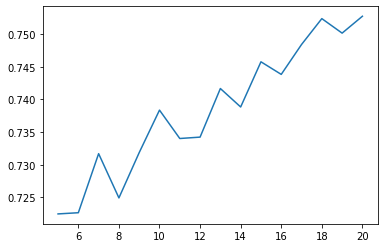

In [ ]:

ks = pd.Series(range(5,21))
ks.index = range(5,21)
test_errs = ks.apply(get_cv_error_descision_tree_maxDepth)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
def get_cv_error_descision_tree_maxFeatures(k):
  # define pipeline
  pipeline = make_pipeline(
      DecisionTreeClassifier(max_features=k)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

2     0.736775
7     0.741967
10    0.742289
6     0.742351
8     0.742591
5     0.743449
4     0.746071
9     0.746591
3     0.747558
dtype: float64

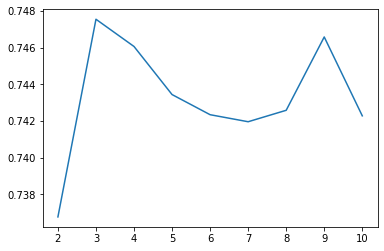

In [ ]:



ks = pd.Series(range(2,11))
ks.index = range(2,11)
test_errs = ks.apply(get_cv_error_descision_tree_maxFeatures)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:

classifier = DecisionTreeClassifier(max_depth=20, max_features=9)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.49      0.50      0.50       265
   SHA-3-256       0.49      0.49      0.49       265

    accuracy                           0.74      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.74      0.74      0.74      1050



In [79]:
def get_cv_error_gbc_max_depth(n):
  # define pipeline
  pipeline = make_pipeline(
      GradientBoostingClassifier(max_depth=n)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

In [81]:
ks = pd.Series(range(5,31))
ks.index = range(5,31)
test_errs = ks.apply(get_cv_error_gbc_max_depth)

test_errs.plot.line()
test_errs.sort_values()

KeyboardInterrupt: ignored

In [ ]:
def get_cv_error_gbc_max_features(n):
  # define pipeline
  pipeline = make_pipeline(
      GradientBoostingClassifier(max_features=n)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

In [ ]:
ks = pd.Series(range(2,11))
ks.index = range(2,11)
test_errs = ks.apply(get_cv_error_gbc_max_features)

test_errs.plot.line()
test_errs.sort_values()

In [77]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.49      0.40      0.44       265
   SHA-3-256       0.49      0.57      0.53       265

    accuracy                           0.74      1050
   macro avg       0.74      0.74      0.74      1050
weighted avg       0.74      0.74      0.74      1050

